## ADAM vs SGD

This is a response to Siraj Raval's [Coding Challenge](https://github.com/llSourcell/The_evolution_of_gradient_descent/) to implement the Adam Optimization Strategy. In this notebook, we are building a 3-layer neural network with numpy for the [Kaggle Titanic Dataset](https://www.kaggle.com/c/titanic/data), and comparing the performance difference between a standard Stochastic Gradient Descent and Adam.

With reference to:
1. [Adam: A method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) by Diederik P. Kingma, Jimmy Ba  
2. [CS231: Neural Networks](http://cs231n.github.io/neural-networks-3/#update) by Andrej Karpathy
3. [Optimizing Gradient Descent](http://sebastianruder.com/optimizing-gradient-descent/index.html#adam) by Sebastian Ruder

In [329]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

## Data Preparation

In [330]:
train = pd.read_csv('train.csv')

# Converting Passenger Class and Embarked Location to binary variables
dummy_fields = ['Sex', 'Pclass', 'Embarked']
for i in dummy_fields:
    dummies = pd.get_dummies(train[i], prefix=i, drop_first=False)
    train = pd.concat([train, dummies], axis=1)

# Dropping unneeded columns 
fields_to_drop = ['PassengerId', 'Ticket', 'Name', 'Cabin', 'Fare', 'Pclass', 'Embarked', 'Sex']
data = train.drop(fields_to_drop, axis=1)

In [331]:
# Normalising Age
mean, std = data['Age'].mean(), data['Age'].std()
data.loc[:, 'Age'] = (data['Age'] - mean)/std

data = data.fillna(0) # Replace NaN age with mean (0)

In [332]:
# Shuffle Data 
data = data.sample(frac=1).reset_index(drop=True)

# Splitting Data into Train Val and Test Set
features, targets = data.drop('Survived', axis=1), data['Survived'] 
targets = targets.values.reshape(-1, 1) # reshaping to numpy n x 1 matrix

test_X, test_y = features[-120:], targets[-120:]
val_X, val_y = features[-200:-120], targets[-200:-120]
train_X, train_y = features[:-200], targets[:-200]

## Neural Network

In [379]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate, weights_init):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.lr = learning_rate
        self.l2_m = 0
        self.l1_m = 0
        self.l2_v = 0
        self.l1_v = 0
        self.t = 0
        self.mu_grads = None
        self.mu_til = None
        self.n = None
        
        # Weights Initilization
        self.w0 = weights_init[0]
        self.w1 = weights_init[1]
        
        def sigmoid(x, deriv=False):
            if deriv:
                return x*(1-x)
            return 1/(1+np.exp(-x))
        
        self.activation_function = sigmoid
        
    def train(self, features, targets, optimizer, decay_rate_1 = None, 
              decay_rate_2 = None, epsilon = None, batch_size=None, is_stage=False, 
              w_til=None, mu_til=None):
        
        def gradients(feat, w0, w1, is_sgd=False):
            # Feed Forward
            l0 = feat
            l1 = self.activation_function(np.dot(l0, w0))
            #print(l0.shape, l1.shape, w0.shape, w1.shape)
            l2 = self.activation_function(np.dot(l1, w1))
            
            #return
            # Backpropagation
            l2_error = l2 - targets
            l2_delta = l2_error * self.activation_function(l2, deriv=True)
            l1_error = l2_delta.dot(w1.T)
            l1_delta = l1_error * self.activation_function(l1, deriv=True)
            if is_sgd:
                return l0, l1, l1_delta, l2_delta
            # Gradients for each layer
            g1 = l1.T.dot(l2_delta)
            g0 = l0.T.dot(l1_delta)
            return g0, g1
        
        #print(is_stage)
        if is_stage:
            #print('start stage')
            self.w_til = [self.w0.copy(), self.w1.copy()]
            g0, g1 = gradients(features, self.w_til[0], self.w_til[1])
            #print('end stage')
            self.n = features.shape[0]/batch_size
            self.mu_grads = [self.n*g0, self.n*g1]
           
            return
        else:
            g0, g1 = gradients(features, self.w0, self.w1)
        
        if optimizer == 'svrg':
            # gradient with w_til
            g_til_0, g_til_1 = gradients(features, self.w_til[0], self.w_til[1])
            #print(g_til_0)
            self.t += 1 # Increment Time Step

            g1 = g1 - g_til_1 + self.mu_grads[1]
            #print(g1[0])
            #if self.t == 40:
            #    return
            g0 = g0 - g_til_0 + self.mu_grads[0]

            self.w1 -= (self.lr * g1)
            self.w0 -= (self.lr * g0)
        
        if optimizer == 'vradam':
            # gradient with w_til
            g_til_0, g_til_1 = gradients(features, self.w_til[0], self.w_til[1])
            
            self.t += 1 # Increment Time Step
            
            g1 = g1 - g_til_1 + self.mu_grads[1]
            g0 = g0 - g_til_0 + self.mu_grads[0]
            
            # Computing 1st and 2nd moment for each layer
            self.l2_m = self.l2_m * decay_rate_1 + (1- decay_rate_1) * g1
            self.l1_m = self.l1_m * decay_rate_1 + (1- decay_rate_1) * g0
            
            self.l2_v = self.l2_v * decay_rate_2 + (1- decay_rate_2) * (g1 ** 2)
            self.l1_v = self.l1_v * decay_rate_2 + (1- decay_rate_2) * (g0 ** 2)
            
            l2_m_corrected = self.l2_m / (1-(decay_rate_1 ** self.t))
            l2_v_corrected = self.l2_v / (1-(decay_rate_2 ** self.t))
            
            # Computing bias-corrected moment
            l1_m_corrected = self.l1_m / (1-(decay_rate_1 ** self.t))
            l1_v_corrected = self.l1_v / (1-(decay_rate_2 ** self.t))
            
            # Update Weights
            w1_update = l2_m_corrected / (np.sqrt(l2_v_corrected) + epsilon)
            w0_update = l1_m_corrected / (np.sqrt(l1_v_corrected) + epsilon)
            
            self.w1 -= (self.lr * w1_update)
            self.w0 -= (self.lr * w0_update)

        if optimizer == 'sgd':
            l0, l1, l1_delta, l2_delta = gradients(features, self.w0, self.w1, is_sgd=True)
            # Update Weights
            self.w1 -= self.lr * l1.T.dot(l2_delta)
            self.w0 -= self.lr * l0.T.dot(l1_delta)
            
        if optimizer == 'adam':
            # Gradients for each layer
            #g1 = l1.T.dot(l2_delta)
            #g0 = l0.T.dot(l1_delta)
            
            self.t += 1 # Increment Time Step
            
            # Computing 1st and 2nd moment for each layer
            self.l2_m = self.l2_m * decay_rate_1 + (1- decay_rate_1) * g1
            self.l1_m = self.l1_m * decay_rate_1 + (1- decay_rate_1) * g0
            
            self.l2_v = self.l2_v * decay_rate_2 + (1- decay_rate_2) * (g1 ** 2)
            self.l1_v = self.l1_v * decay_rate_2 + (1- decay_rate_2) * (g0 ** 2)
            
            l2_m_corrected = self.l2_m / (1-(decay_rate_1 ** self.t))
            l2_v_corrected = self.l2_v / (1-(decay_rate_2 ** self.t))
            
            # Computing bias-corrected moment
            l1_m_corrected = self.l1_m / (1-(decay_rate_1 ** self.t))
            l1_v_corrected = self.l1_v / (1-(decay_rate_2 ** self.t))
            
            # Update Weights
            w1_update = l2_m_corrected / (np.sqrt(l2_v_corrected) + epsilon)
            w0_update = l1_m_corrected / (np.sqrt(l1_v_corrected) + epsilon)
            
            self.w1 -= (self.lr * w1_update)
            self.w0 -= (self.lr * w0_update)
            
    def run(self, features):
        l0 = features
        l1 = self.activation_function(np.dot(l0, self.w0))
        l2 = self.activation_function(np.dot(l1, self.w1))
        
        return l2


In [380]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training

In [381]:
12%12

0

In [386]:
import time

def build_network(network, epochs, optimizer, batch_size = None, stage_size=None):
    losses = {'train':[], 'validation':[]} # For Plotting of MSE
    
    start = time.time()
    train_loss = MSE(network.run(train_X), train_y)
    val_loss = MSE(network.run(val_X), val_y)
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)
    print(range(train_X.shape[0]// batch_size))
    n = train_X.shape[0]
    print(n)
    #w_tilde_old = []
    #w_tilde_old.append(np.random.normal(0.0, 0.1, (network.input_nodes, network.hidden_nodes)))
    #w_tilde_old.append(np.random.normal(0.0, 0.1, (network.hidden_nodes, network.output_nodes)))
    #print(w_tilde_old[0].shape)
    # Iterating Over Epochs
    for i in range(epochs):
        if optimizer == 'sgd':
            # Iterating over mini batches
            for k in range(train_X.shape[0]// batch_size):
                batch = np.random.choice(train_X.index, size=batch_size)
                X, y = train_X.ix[batch].values, train_y[batch]

                network.train(X, y, optimizer)

            train_loss = MSE(network.run(train_X), train_y)
            val_loss = MSE(network.run(val_X), val_y)

            if i % 100 == 0:
                print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(i, train_loss, val_loss))
                
        if optimizer == 'adam':
            # Iterating over mini batches
            for k in range(train_X.shape[0]// batch_size):
                batch = np.random.choice(train_X.index, size=batch_size)
                X, y = train_X.ix[batch].values, train_y[batch]
                network.train(X, 
                              y, 
                              optimizer,
                              decay_rate_1 = 0.9,
                              decay_rate_2 = 0.99,
                              epsilon = 10e-8)

            train_loss = MSE(network.run(train_X), train_y)
            val_loss = MSE(network.run(val_X), val_y)

            if i % 100 == 0:
                print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(i, train_loss, val_loss))

                
        if optimizer == 'vradam':
            decay_1 = 0.9
            decay_2 = 0.99
            eps = 10e-8
            
            for k in range(train_X.shape[0]// batch_size):

                if k % stage_size == 0:
                    #print('stage {}'.format(k))
            #w_tilde = w_tilde_old
            # full grads with tilde
                    network.train(train_X.values, train_y, optimizer, decay_rate_1 = decay_1, 
                                  decay_rate_2 = decay_2, epsilon = eps,
                                  batch_size=batch_size,
                                  is_stage=True)

                else:

                    batch = np.random.choice(train_X.index, size=batch_size)
                    X, y = train_X.ix[batch].values, train_y[batch]
                    network.train(X, 
                                  y, 
                                  optimizer,
                                  decay_rate_1 = decay_1,
                                  decay_rate_2 = decay_2,
                                  epsilon = eps,
                                  batch_size=batch_size)

            #w_tilde_old = [network.w0, network.w1]
            train_loss = MSE(network.run(train_X), train_y)
            val_loss = MSE(network.run(val_X), val_y)

            if i % 100 == 0:
                print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(i, train_loss, val_loss))
        
        if optimizer == 'svrg':
            #print('svrg')
            decay_1 = 0.9
            decay_2 = 0.99
            eps = 10e-8
            
            for k in range(train_X.shape[0]// batch_size):

                if k % stage_size == 0:
                    #print('stage {}'.format(k))
            #w_tilde = w_tilde_old
            # full grads with tilde
                    network.train(train_X.values, train_y, optimizer, decay_rate_1 = decay_1, 
                                  decay_rate_2 = decay_2, epsilon = eps,
                                  batch_size=batch_size,
                                  is_stage=True)

                else:

                    batch = np.random.choice(train_X.index, size=batch_size)
                    X, y = train_X.ix[batch].values, train_y[batch]
                    network.train(X, 
                                  y, 
                                  optimizer,
                                  decay_rate_1 = decay_1,
                                  decay_rate_2 = decay_2,
                                  epsilon = eps,
                                  batch_size=batch_size)

            #w_tilde_old = [network.w0, network.w1]
            train_loss = MSE(network.run(train_X), train_y)
            val_loss = MSE(network.run(val_X), val_y)

            if i % 100 == 0:
                print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(i, train_loss, val_loss))

        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
    print('Time Taken:{0:.4f}s'.format(time.time()-start))
    return losses

In [391]:
epochs = 1200
learning_rate = 0.0001
hidden_nodes = 15
output_nodes = 1
batch_size = 64

init_w0 = np.random.normal(0.0, 0.1, (train_X.shape[1], hidden_nodes))
init_w1 = np.random.normal(0.0, 0.1, (hidden_nodes, output_nodes))

init_weights = [init_w0.copy(), init_w1.copy()]
network_adam = NeuralNetwork(train_X.shape[1], hidden_nodes, output_nodes, learning_rate, init_weights)
init_weights = [init_w0.copy(), init_w1.copy()]
network_sgd = NeuralNetwork(train_X.shape[1], hidden_nodes, output_nodes, learning_rate, init_weights)
init_weights = [init_w0.copy(), init_w1.copy()]
network_vradam = NeuralNetwork(train_X.shape[1], hidden_nodes, output_nodes, learning_rate, init_weights)
init_weights = [init_w0.copy(), init_w1.copy()]
network_svrg = NeuralNetwork(train_X.shape[1], hidden_nodes, output_nodes, learning_rate, init_weights)

print('Training Model with Adam')
losses_adam = build_network(network_adam, epochs, 'adam', batch_size)

print('\nTraining Model with SGD')
losses_sgd = build_network(network_sgd, epochs, 'sgd', batch_size)

print('Training Model with Vradam')
losses_vradam = build_network(network_vradam, epochs, 'vradam', batch_size, stage_size=60)

print('Training Model with SVRG')
losses_svrg = build_network(network_svrg, epochs, 'svrg', batch_size, stage_size=60)

Training Model with Adam
range(0, 10)
691
Epoch 0, Train Loss: 0.25930011886802423, Val Loss: 0.25637459167084387


/Users/luizfelipe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Epoch 100, Train Loss: 0.23195358634012905, Val Loss: 0.23918474158396155
Epoch 200, Train Loss: 0.22106530211762654, Val Loss: 0.23178084942165053
Epoch 300, Train Loss: 0.2064337196007657, Val Loss: 0.2202043746795888
Epoch 400, Train Loss: 0.19069196802406868, Val Loss: 0.20711388527207472
Epoch 500, Train Loss: 0.1759774675993148, Val Loss: 0.19285014563926434
Epoch 600, Train Loss: 0.16428044453043486, Val Loss: 0.18147968184489333
Epoch 700, Train Loss: 0.15562740665059938, Val Loss: 0.17168046663326883
Epoch 800, Train Loss: 0.14980195575521754, Val Loss: 0.16534067208564088
Epoch 900, Train Loss: 0.14635831507952407, Val Loss: 0.16124072623921437
Epoch 1000, Train Loss: 0.14422000149701056, Val Loss: 0.1592826844338766
Epoch 1100, Train Loss: 0.14284584973048678, Val Loss: 0.15788031585839826
Time Taken:17.7700s

Training Model with SGD
range(0, 10)
691
Epoch 0, Train Loss: 0.25918848945310957, Val Loss: 0.2563167138200052


/Users/luizfelipe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Epoch 100, Train Loss: 0.2380709604496564, Val Loss: 0.24398490627251182
Epoch 200, Train Loss: 0.23643397709040845, Val Loss: 0.244248282234927
Epoch 300, Train Loss: 0.23573093697827027, Val Loss: 0.24425409245315333
Epoch 400, Train Loss: 0.2350909238696332, Val Loss: 0.24372338412020414
Epoch 500, Train Loss: 0.2344086435304127, Val Loss: 0.2430248851254592
Epoch 600, Train Loss: 0.23367402145733104, Val Loss: 0.2422686140391929
Epoch 700, Train Loss: 0.2328890476828105, Val Loss: 0.24158963104840864
Epoch 800, Train Loss: 0.23202446549476147, Val Loss: 0.2408204313567724
Epoch 900, Train Loss: 0.23106986836032029, Val Loss: 0.23998744860794746
Epoch 1000, Train Loss: 0.23000037045180557, Val Loss: 0.23865022995955038
Epoch 1100, Train Loss: 0.2288188266785304, Val Loss: 0.23751959079228877
Time Taken:16.4049s
Training Model with Vradam
range(0, 10)
691
Epoch 0, Train Loss: 0.2593021431027837, Val Loss: 0.2563764342785364


/Users/luizfelipe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Epoch 100, Train Loss: 0.23100645738126468, Val Loss: 0.2391901418747157
Epoch 200, Train Loss: 0.21470750946612038, Val Loss: 0.2290703113577432
Epoch 300, Train Loss: 0.19529942940862674, Val Loss: 0.21302061652402338
Epoch 400, Train Loss: 0.17575492401669626, Val Loss: 0.19556056874609123
Epoch 500, Train Loss: 0.1592816486322724, Val Loss: 0.1789608885209375
Epoch 600, Train Loss: 0.14786874183805584, Val Loss: 0.16514157031143778
Epoch 700, Train Loss: 0.14165504917480512, Val Loss: 0.1562222896096191
Epoch 800, Train Loss: 0.13880762085739196, Val Loss: 0.1529423441660188
Epoch 900, Train Loss: 0.13692851725430802, Val Loss: 0.1526228125147079
Epoch 1000, Train Loss: 0.13508340794913604, Val Loss: 0.15146025032974955
Epoch 1100, Train Loss: 0.1330561814842474, Val Loss: 0.1494294169478336
Time Taken:14.7272s
Training Model with SVRG
range(0, 10)
691
Epoch 0, Train Loss: 0.2421200193100226, Val Loss: 0.256132243988213


/Users/luizfelipe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Epoch 100, Train Loss: 0.14000508452300264, Val Loss: 0.15544028101359442
Epoch 200, Train Loss: 0.1378625289950205, Val Loss: 0.15685142093465942
Epoch 300, Train Loss: 0.1359509927335282, Val Loss: 0.1555379464033161
Epoch 400, Train Loss: 0.13320437278586358, Val Loss: 0.15216369398165108
Epoch 500, Train Loss: 0.13039445021690646, Val Loss: 0.1479461226477393
Epoch 600, Train Loss: 0.1281754790709508, Val Loss: 0.1443796405389977
Epoch 700, Train Loss: 0.12661249476951716, Val Loss: 0.1418533070866596
Epoch 800, Train Loss: 0.12556532142638435, Val Loss: 0.140155133638012
Epoch 900, Train Loss: 0.12484228670005691, Val Loss: 0.13906061428131905
Epoch 1000, Train Loss: 0.12430444534282675, Val Loss: 0.1384246503062286
Epoch 1100, Train Loss: 0.12386922672614671, Val Loss: 0.138135006291075
Time Taken:13.7907s


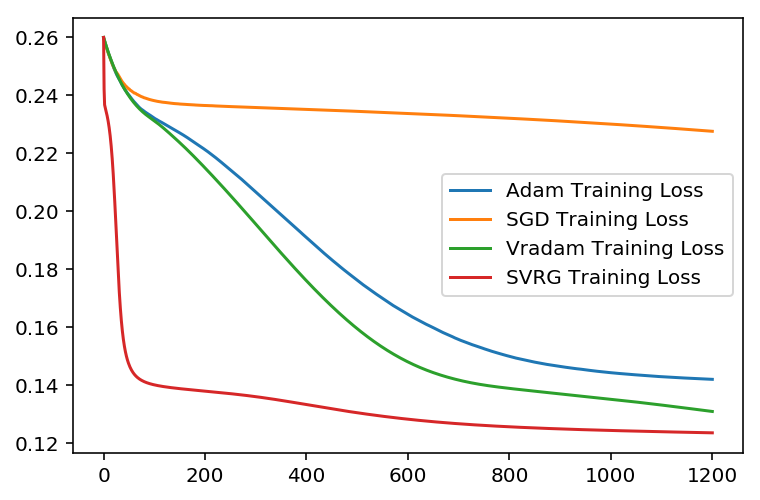

In [392]:
plt.plot(losses_adam['train'], label='Adam Training Loss')
#plt.plot(losses_adam['validation'], label='Adam Validation Loss')
plt.plot(losses_sgd['train'], label='SGD Training Loss')
#plt.plot(losses_sgd['validation'], label='SGD Validation Loss')
plt.plot(losses_vradam['train'], label='Vradam Training Loss')
plt.plot(losses_svrg['train'], label='SVRG Training Loss')
plt.legend()
#_ = plt.ylim()

From the plots, we can observed that using Adam, weights of the neural network are more smoothly adjusted to reduce the training loss. Try increasing the learning rate, and you can see that Adam converges much faster compared to SGD, using an adaptive learning rate.

The benefits of using Adam are not so obvious as the size of the data is very small and increasing training epochs tend to lead to overfitting and early-stopping is required. It is recommended to set the epochs for Adam to around 200 for the above hyperparameters configuration, as the training and validation loss starts diverging. However, we kept the epochs for both networks the same for plotting.

Lastly, in this implementation, Adam is much faster to compute compared to SGD as it is processed as an entire training batch.  

## Test Model

Here, we will compare between the models trained wih Adam and SGD on the test set.

In [213]:
network_vradam.w0.copy()

array([[ 0.36833136,  0.57642506,  0.48391093,  0.13797108],
       [ 0.09054967,  0.22118765,  0.17925458, -0.31568434],
       [-0.12348823, -0.39299585, -0.25713291, -0.47790732],
       [-0.41823624, -0.4539356 , -0.56111496, -0.20466285],
       [ 0.19627821,  0.40111742,  0.33024536,  0.19917648],
       [-0.57123976, -0.49724788, -0.31590105, -0.12331854],
       [-0.2046578 , -0.35586984, -0.27332082, -0.571436  ],
       [ 0.50564054,  0.50741331,  0.479218  ,  0.23166428],
       [-0.40528331, -0.38338518, -0.43822034, -0.13536775],
       [ 0.29193203,  0.19159439,  0.17396824,  0.0436341 ],
       [ 0.37254269,  0.21440352,  0.26129528, -0.16076237]])

In [735]:
def test_model(network):
    test_predictions = network.run(test_X)
    correct = 0
    total = 0
    for i in range(len(test_predictions)):
        total += 1
        if test_predictions[i] < 0.5 and test_y[i] == 0:
            correct += 1
        elif test_predictions[i] >= 0.5 and test_y[i] == 1:
            correct += 1
    return correct/total
    

In [736]:
print('Adam Test Accuracy: {}'.format(test_model(network_adam)))
print('SGD Test Accuracy: {}'.format(test_model(network_sgd)))

Adam Test Accuracy: 0.85
SGD Test Accuracy: 0.85


With an accuracy of 85%, we are placed under the top 100 for the Titanic Machine Learning challenge! Try adding more layers/ dropout to the neural network or swapping out sigmoid for relu or optimize the hyperparameters to improve the accuracy.